# Week 5. Training Issues
Through the previous learning, you may have already known how to train a model from scratch. In this part, we will firstly review the whole training process by setting up a classification network on MNIST dataset. Then we will highlight some useful tricks to improve the model performance.

If you have any questions or suggestions about this part, please feel free to contact the teaching assistants Wanying Tao and Jianfei Xing on WeChat.
  

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Common Setup

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision.datasets import MNIST
import torchvision
from torchvision import transforms
from torch.optim import lr_scheduler
from collections import OrderedDict
import matplotlib.pyplot as plt

In [3]:
# cuda = torch.cuda.is_available() 
# torch.cuda.set_device(device) 

# Limited by GPU resources, we recommend computing on CPU
# device = torch.device('cpu')
device = torch.device('cuda') 

## 2. Classfication Model

In [4]:
class FeedForwardNeuralNetwork(nn.Module):
    """
    Inputs                Linear/Function        Output
    [128, 1, 28, 28]   -> Linear(28*28, 100) -> [128, 100]  # the first hidden layer
                       -> ReLU               -> [128, 100]  # ReLU activation function, may Sigmoid
                       -> Linear(100, 100)   -> [128, 100]  # the second hidden layer
                       -> ReLU               -> [128, 100]  # ReLU activation function, may Sigmoid
                       -> Linear(100, 100)   -> [128, 100]  # the third hidden layer
                       -> ReLU               -> [128, 100]  # ReLU activation function, may Sigmoid
                       -> Linear(100, 10)    -> [128, 10]   # classification layer                                                          
   """
    def __init__(self, input_size, hidden_size, output_size, activation_function='RELU'):
        super(FeedForwardNeuralNetwork, self).__init__()
        self.use_dropout = False
        self.use_bn = False
        self.hidden1 = nn.Linear(input_size, hidden_size)  # Linear function 1: 784 --> 100 
        self.hidden2 = nn.Linear(hidden_size, hidden_size) # Linear function 2: 100 --> 100
        self.hidden3 = nn.Linear(hidden_size, hidden_size) # Linear function 3: 100 --> 100
        # Linear function 4 (readout): 100 --> 10
        self.classification_layer = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.5) # Drop out with prob = 0.5
        self.hidden1_bn = nn.BatchNorm1d(hidden_size) # Batch Normalization 
        self.hidden2_bn = nn.BatchNorm1d(hidden_size)
        self.hidden3_bn = nn.BatchNorm1d(hidden_size)
        
        # Non-linearity
        if activation_function == 'SIGMOID':
            self.activation_function1 = nn.Sigmoid()
            self.activation_function2 = nn.Sigmoid()
            self.activation_function3 = nn.Sigmoid()
        elif activation_function == 'RELU':
            self.activation_function1 = nn.ReLU()
            self.activation_function2 = nn.ReLU()
            self.activation_function3 = nn.ReLU()
        
    def forward(self, x):
        """
        Args:
            x: [batch_size, channel, height, width], network input
        Returns:
            out: [batch_size, n_classes], network output
        """
        
        x = x.view(x.size(0), -1) # flatten x in [128, 784]
        out = self.hidden1(x)
        out = self.activation_function1(out) # Non-linearity 1
        if self.use_bn == True:
            out = self.hidden1_bn(out)
        out = self.hidden2(out)
        out = self.activation_function2(out)
        if self.use_bn == True:
            out = self.hidden2_bn(out)
        out = self.hidden3(out)
        if self.use_bn == True:
            out = self.hidden3_bn(out)
        out = self.activation_function3(out)
        if self.use_dropout == True:
            out = self.dropout(out)
        out = self.classification_layer(out)
        return out
    
    def set_use_dropout(self, use_dropout):
        """Whether to use dropout. Auxiliary function for our exp, not necessary.
        Args:
            use_dropout: True, False
        """
        self.use_dropout = use_dropout
        
    def set_use_bn(self, use_bn):
        """Whether to use batch normalization. Auxiliary function for our exp, not necessary.
        Args:
            use_bn: True, False
        """
        self.use_bn = use_bn
        
    def get_grad(self):
        """Return average grad for hidden2, hidden3. Auxiliary function for our exp, not necessary.
        """
        hidden2_average_grad = np.mean(np.sqrt(np.square(self.hidden2.weight.grad.detach().to("cpu").numpy())))
        hidden3_average_grad = np.mean(np.sqrt(np.square(self.hidden3.weight.grad.detach().to("cpu").numpy())))
        return hidden2_average_grad, hidden3_average_grad

## 3. Training  

### 3.1 Pre-set hyper-parameters
* learning rate: usually set the learning rate to 1e-1, 1e-2 or 1e-3, and gradually decrease its value during iteration.
* n_epochs: training epoch must be set large enough to ensure that the model can converge. 
* batch_size: bigger batch size means better usage of GPU and less time for model to converge, generally use the exponent power of 2, e.g., 2, 4, 8, 16, 32, 64, 128, 256.  

In [5]:
### Hyper parameters

batch_size = 128 # batch size is 128
n_epochs = 5 # train 5 epochs
learning_rate = 0.01 # learning rate is 0.01
input_size = 28*28 # tthe size of image is 28x28
hidden_size = 100 # 100 hidden neurons in each layer
output_size = 10 # classes of prediction
l2_norm = 0 # not to use l2 penalty
dropout = False # not to use dropout
get_grad = False # not to obtain grad

In [6]:
# create a model object
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# loss function
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

### 3.2 Initialize model parameters
PyTorch provides default initialization (**uniform intialization**) for linear layer, and there are also some other useful initialization methods you may use in the homework.

Click on this [link](https://pytorch.org/docs/stable/_modules/torch/nn/init.html) for more details.

In [45]:
def show_weight_bias(model):
    """Show weights and bias distribution. 
    """
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(2,3, sharey=False, tight_layout=True)
    
    # weight and bias for every hidden layer
    h1_w = model.hidden1.weight.detach().to("cpu").numpy().flatten()
    h1_b = model.hidden1.bias.detach().to("cpu").numpy().flatten()
    h2_w = model.hidden2.weight.detach().to("cpu").numpy().flatten()
    h2_b = model.hidden2.bias.detach().to("cpu").numpy().flatten()
    h3_w = model.hidden3.weight.detach().to("cpu").numpy().flatten()
    h3_b = model.hidden3.bias.detach().to("cpu").numpy().flatten()
    
    axs[0,0].hist(h1_w)
    axs[0,1].hist(h2_w)
    axs[0,2].hist(h3_w)
    axs[1,0].hist(h1_b)
    axs[1,1].hist(h2_b)
    axs[1,2].hist(h3_b)
    
    # set title for every sub plots
    axs[0,0].set_title('hidden1_weight')
    axs[0,1].set_title('hidden2_weight')
    axs[0,2].set_title('hidden3_weight')
    axs[1,0].set_title('hidden1_bias')
    axs[1,1].set_title('hidden2_bias')
    axs[1,2].set_title('hidden3_bias')

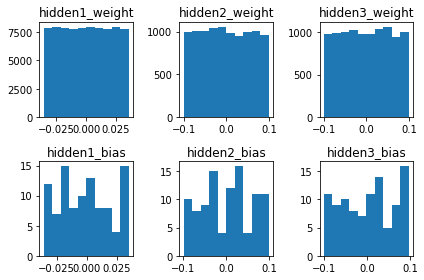

In [8]:
show_weight_bias(model)

In [9]:
def weight_bias_reset(model):
    """Custom initialization, you can imitate the code writing to use other initialization methods in homework.
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            mean, std = 0, 0.1 
            
            torch.nn.init.normal_(m.weight, mean, std)
            torch.nn.init.normal_(m.bias, mean, std)
            
#             m.weight.data.normal_(mean, std)
#             m.bias.data.normal_(mean, std)

## 作业1
使用constant, xavier, kaiming三种方式初始化参数，并显示模型隐藏层的参数分布，不必初始化bias。

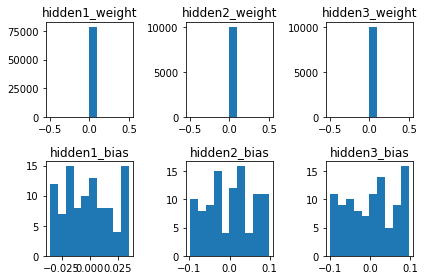

In [10]:
# TODO

def weight_bias_reset_constant(model):
    """Constant initalization
    """
    # remove pass and code here
    for mod in model.modules():
        if isinstance(mod, nn.Linear):
            torch.nn.init.constant_(mod.weight, 0)
            # 按照题目要求，没有初始化bias
        
# Reset parameters and show the distribution
weight_bias_reset_constant(model)
show_weight_bias(model)

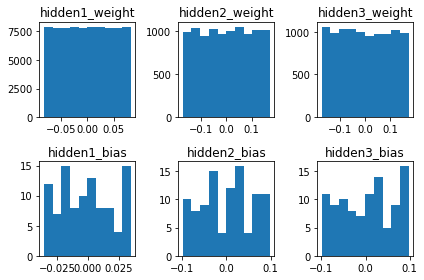

In [11]:
# TODO

def weight_bias_reset_xavier_uniform(model):
    """xaveir_uniform, gain=1
    """
    # remove pass and code here
    for mod in model.modules():
        if isinstance(mod, nn.Linear):
            torch.nn.init.xavier_uniform_(mod.weight, gain=1.0)
        
# Reset parameters and show the distribution
weight_bias_reset_xavier_uniform(model)
show_weight_bias(model)

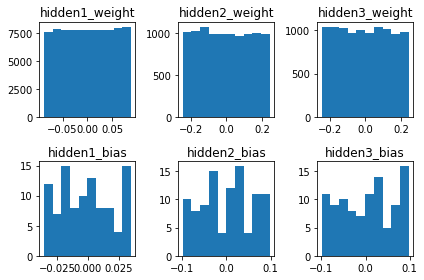

In [12]:
# TODO

def weight_bias_reset_kaiming_uniform(model):
    """kaiming_uniform, a=0, mode='fan_in', nonlinearity='relu'
    """
    # remove pass and code here
    for mod in model.modules():
        if isinstance(mod, nn.Linear):
            nn.init.kaiming_uniform_(mod.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        
# Reset parameters and show the distribution
weight_bias_reset_kaiming_uniform(model)
show_weight_bias(model)

### 3.3 Repeat over certain numbers of epoch

#### 3.3.1 data loading 
Please pay attention to data augmentation. 

Click on this [link](https://pytorch.org/docs/stable/torchvision/transforms.html). for more details.

```
torchvision.transforms.RandomVerticalFlip
torchvision.transforms.RandomHorizontalFlip
...
```


In [13]:
train_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [14]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                            train=True, 
                            transform=train_transform,
                            download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                           train=False, 
                           transform=test_transform,
                           download=False)

In [15]:
# train_dataset doesn't load any data, it just defines some method and stores some message to preprocess data
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

#### 3.3.2 model training

In [17]:
def train(train_loader, model, loss_fn, optimizer, get_grad=False):
    """
    Args:
        train_loader: training data
        model: prediction model
        loss_fn: loss function to calculate the distance between target and outputs
        optimizer: optimize the loss function
        get_grad: True, False
    Returns:
        total_loss: loss
        average_grad2: average grad for hidden 2 in this epoch
        average_grad3: average grad for hidden 3 in this epoch
    """
    model.train()
    
    total_loss = 0
    grad_2 = 0.0 # store sum(grad) for hidden 2 layer
    grad_3 = 0.0 # store sum(grad) for hidden 3 layer
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() 
        outputs = model(data)
        loss = loss_fn(outputs, target)  
        total_loss += loss.item() 
        loss.backward() 
        
        if get_grad == True:
            g2, g3 = model.get_grad() # get gradients of hiddern 2 and 3 layer in this batch
            grad_2 += g2
            grad_3 += g3 
            
        optimizer.step() 
            
    average_loss = total_loss / batch_idx 
    average_grad2 = grad_2 / batch_idx 
    average_grad3 = grad_3 / batch_idx 
    
    return average_loss, average_grad2, average_grad3

#### 3.3.3 model evaluation

In [18]:
def evaluate(val_loader, model, loss_fn):
    """
    Args:
        val_loader: data for evaluation
        model: prediction model
        loss_fn: loss function to calculate the distance between target and outputs
    Returns:
        total_loss:loss
        accuracy: model prediction accuracy
    """
    with torch.no_grad():
        
        model.eval()       
        correct = 0.0
        total_loss = 0  
        
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            outputs = model(data) 
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().to("cpu").detach().numpy()
            loss = loss_fn(outputs, target)
            total_loss += loss.item() 
            
        accuracy = correct*100.0 / len(val_loader.dataset) 
        
    return total_loss, accuracy

In [19]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, n_epochs, get_grad=False):
    """
    Args: 
        train_loader: training data
        val_loader: validation data
        model: prediction model
        loss_fn: loss function to calculate the distance between target and outputs
        optimizer: optimize the loss function
        n_epochs: training epochs
        get_grad: whether to get gradients of hidden2 layer and hidden3 layer or not
    Returns:
        train_accs: accuracy of training n_epochs, a list
        train_losses: loss of n_epochs, a list
    """
    
    grad_2 = [] 
    grad_3 = []
    
    train_accs = [] 
    train_losses = []
    
    for epoch in range(n_epochs): 
        
        train_loss, average_grad2, average_grad3 = train(train_loader, model, loss_fn, optimizer, get_grad)
        
        _, train_accuracy = evaluate(train_loader, model, loss_fn)
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, \
                                                                n_epochs, train_loss, train_accuracy)
        print(message)
    
        # save loss, accuracy, grad
        train_accs.append(train_accuracy)
        train_losses.append(train_loss)
        grad_2.append(average_grad2)
        grad_3.append(average_grad3)
    
        # evaluate model performance on val dataset
        val_loss, val_accuracy = evaluate(val_loader, model, loss_fn)
        message = 'Epoch: {}/{}. Validation set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, \
                                                                n_epochs, val_loss, val_accuracy)
        print(message)
        
    if get_grad == True:
        fig, ax = plt.subplots() 
        ax.plot(grad_2, label='Gradients of Hidden 2 Layer') 
        ax.plot(grad_3, label='Gradients of Hidden 3 Layer') 
        plt.ylim(top=0.004)
        # place a legend on axes
        legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
    
    return train_accs, train_losses

In [20]:
def show_curve(ys, title):
    """
    Args:
        ys: loss or acc list
        title: Loss or Accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} Curve:'.format(title))
    plt.xlabel('Epoch')
    plt.ylabel('{} Value'.format(title))
    plt.show()

## 作业 2
将n_epochs依次设为5和10，画出训练过程中loss和accuracy的变化曲线，分别观察模型在训练集上的拟合情况。

Hints: 因为jupyter对变量有上下文关系，模型和优化器需要重新声明。

In [23]:
# TODO

# set hyper parameters and declare model, optimizer
# code here
model_5_epoch = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
optimizer_5 = torch.optim.SGD(model_5_epoch.parameters(), lr=learning_rate, weight_decay=l2_norm)
model_10_epoch = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
optimizer_10 = torch.optim.SGD(model_10_epoch.parameters(), lr=learning_rate, weight_decay=l2_norm)

In [24]:
# TODO

# train and evaluate model
# code here
acc_5, loss_5 = fit(train_loader, test_loader, model_5_epoch, loss_fn, optimizer_5, 5, get_grad=False)
acc_10, loss_10 = fit(train_loader, test_loader, model_10_epoch, loss_fn, optimizer_10, 10, get_grad=False)

Epoch: 1/5. Train set: Average loss: 1.9120, Accuracy: 77.7417
Epoch: 1/5. Validation set: Average loss: 69.7787, Accuracy: 78.2800
Epoch: 2/5. Train set: Average loss: 0.5612, Accuracy: 87.3717
Epoch: 2/5. Validation set: Average loss: 32.2927, Accuracy: 87.9900
Epoch: 3/5. Train set: Average loss: 0.3776, Accuracy: 89.6200
Epoch: 3/5. Validation set: Average loss: 26.5033, Accuracy: 89.8800
Epoch: 4/5. Train set: Average loss: 0.3214, Accuracy: 90.9283
Epoch: 4/5. Validation set: Average loss: 23.2946, Accuracy: 91.1200
Epoch: 5/5. Train set: Average loss: 0.2843, Accuracy: 91.9300
Epoch: 5/5. Validation set: Average loss: 20.8676, Accuracy: 92.1000
Epoch: 1/10. Train set: Average loss: 1.8179, Accuracy: 80.3767
Epoch: 1/10. Validation set: Average loss: 59.7393, Accuracy: 80.6400
Epoch: 2/10. Train set: Average loss: 0.5246, Accuracy: 87.5367
Epoch: 2/10. Validation set: Average loss: 31.8400, Accuracy: 87.9000
Epoch: 3/10. Train set: Average loss: 0.3730, Accuracy: 89.7383
Epoch: 3

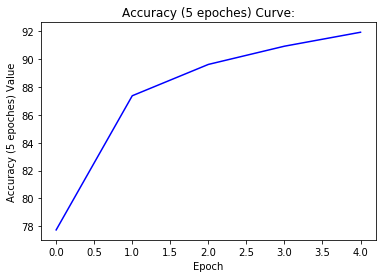

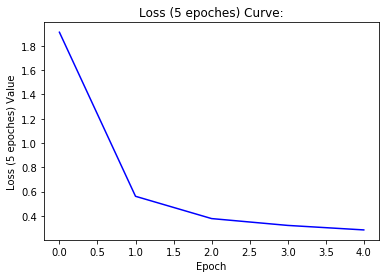

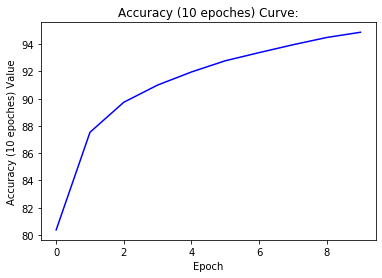

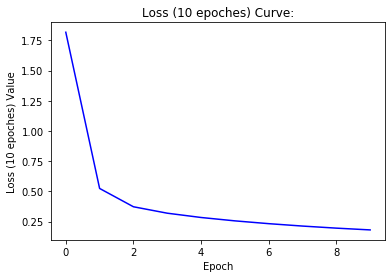

In [25]:
# TODO

# show curve
# code here
show_curve(acc_5,"Accuracy (5 epoches)")
show_curve(loss_5,"Loss (5 epoches)")
show_curve(acc_10,"Accuracy (10 epoches)")
show_curve(loss_10,"Loss (10 epoches)")

A: 可以看到训练的epoch越多，模型在训练集上的精度也就越高，同时训练的loss也在不断下降；但无论是精度提升的速率，还是loss下降的速率都在放缓。

## 作业 3
适当调整其他参数，使模型能在5个epoch内在训练集上达到过拟合，画出训练过程中loss和accuracy的变化曲线。

In [26]:
# TODO

# set hyper parameters
# code here
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=1024, output_size=output_size).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, weight_decay=0) # make it overfit

In [27]:
# TODO

# train and evaluate model
# code here
acc, loss = fit(train_loader, test_loader, model, loss_fn, optimizer, 5, get_grad=False)

Epoch: 1/5. Train set: Average loss: 0.3922, Accuracy: 94.9400
Epoch: 1/5. Validation set: Average loss: 14.7935, Accuracy: 94.2700
Epoch: 2/5. Train set: Average loss: 0.0996, Accuracy: 97.8817
Epoch: 2/5. Validation set: Average loss: 8.1499, Accuracy: 96.9900
Epoch: 3/5. Train set: Average loss: 0.0570, Accuracy: 98.6267
Epoch: 3/5. Validation set: Average loss: 7.0188, Accuracy: 97.4300
Epoch: 4/5. Train set: Average loss: 0.0373, Accuracy: 98.6850
Epoch: 4/5. Validation set: Average loss: 7.2109, Accuracy: 97.3100
Epoch: 5/5. Train set: Average loss: 0.0263, Accuracy: 98.7733
Epoch: 5/5. Validation set: Average loss: 8.1582, Accuracy: 97.4100


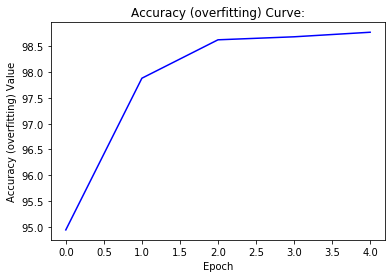

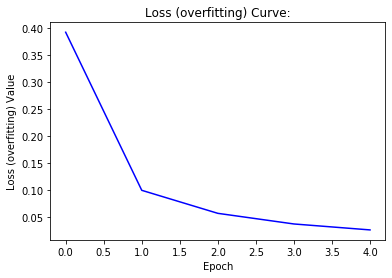

In [28]:
# TODO

# show curve
# code here
show_curve(acc,"Accuracy (overfitting)")
show_curve(loss,"Loss (overfitting)")

A: 可以看到通过增加模型参数数目，使得模型复杂度高于训练集数量级，就会导致模型过拟合。表现为在训练集上的Loss不断下降，准确率不断提升；但是测试集上的Loss开始反弹上升，准确率下降（看第4第5个epoch）。

### 3.4 save model 
PyTorch provides two methods to save the model. And we recommend the one that only saves parameters, because it's more flexible.

A common PyTorch convention is to save models using either a .pt or .pth file extension.

Click on this [link](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for more details.

In [29]:
# show parameters in model
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("\nOptimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
hidden1.weight 	 torch.Size([1024, 784])
hidden1.bias 	 torch.Size([1024])
hidden2.weight 	 torch.Size([1024, 1024])
hidden2.bias 	 torch.Size([1024])
hidden3.weight 	 torch.Size([1024, 1024])
hidden3.bias 	 torch.Size([1024])
classification_layer.weight 	 torch.Size([10, 1024])
classification_layer.bias 	 torch.Size([10])
hidden1_bn.weight 	 torch.Size([1024])
hidden1_bn.bias 	 torch.Size([1024])
hidden1_bn.running_mean 	 torch.Size([1024])
hidden1_bn.running_var 	 torch.Size([1024])
hidden1_bn.num_batches_tracked 	 torch.Size([])
hidden2_bn.weight 	 torch.Size([1024])
hidden2_bn.bias 	 torch.Size([1024])
hidden2_bn.running_mean 	 torch.Size([1024])
hidden2_bn.running_var 	 torch.Size([1024])
hidden2_bn.num_batches_tracked 	 torch.Size([])
hidden3_bn.weight 	 torch.Size([1024])
hidden3_bn.bias 	 torch.Size([1024])
hidden3_bn.running_mean 	 torch.Size([1024])
hidden3_bn.running_var 	 torch.Size([1024])
hidden3_bn.num_batches_tracked 	 torch.Size([])

Optimizer's sta

In [30]:
# save model
save_path = './model.pt'
torch.save(model.state_dict(), save_path)

In [31]:
# load parameters from files
saved_parameters = torch.load(save_path)
print(saved_parameters)

OrderedDict([('hidden1.weight', tensor([[-9.6114e-05, -2.2861e-02,  7.1523e-03,  ...,  3.2509e-02,
          1.0060e-02, -1.2331e-02],
        [ 1.8380e-02, -2.7287e-02, -9.8349e-03,  ...,  1.7592e-02,
          7.6233e-04, -2.3377e-02],
        [ 3.4052e-03, -1.9219e-02,  1.2075e-02,  ...,  1.7066e-02,
         -2.8297e-02, -2.6137e-03],
        ...,
        [ 2.7603e-02,  2.1834e-02, -1.1217e-02,  ..., -4.0312e-03,
         -1.1030e-02, -5.3624e-04],
        [-4.3779e-03,  2.2001e-02, -1.5303e-02,  ...,  3.1514e-02,
          2.6834e-02,  1.8025e-02],
        [-4.4720e-03,  3.7890e-02,  1.1568e-02,  ..., -1.8087e-02,
         -2.9599e-02,  3.1759e-02]], device='cuda:0')), ('hidden1.bias', tensor([ 0.0218, -0.0269, -0.0185,  ..., -0.0083, -0.0357,  0.0017],
       device='cuda:0')), ('hidden2.weight', tensor([[ 0.0059, -0.0298, -0.0057,  ..., -0.0169, -0.0191,  0.0226],
        [ 0.0049, -0.0159, -0.0031,  ..., -0.0237, -0.0143, -0.0066],
        [-0.0313,  0.0186,  0.0135,  ..., -0.0

In [32]:
# initialize model with saved parameters
new_model = FeedForwardNeuralNetwork(input_size, 1024, output_size) # hidden_size changed here
new_model.load_state_dict(saved_parameters)

<All keys matched successfully>

## 4. Training Tricks

### 4.1 l2_norm

# 作业 4 
思考正则项的作用，将l2_norm的值分别设置为0.01和1, 训练模型，观察和不使用l2_norm的结果之间的差异。

Hint：we could minimize the regularization term by using $weight\_decay$ in **SGD optimizer**


In [35]:
# TODO: l2_norm=0.01

# set hyper parameters and declare model, optimizer
# code here
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=1024, output_size=output_size).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.01)

In [36]:
# TODO

# train and evaluate model
# code here
acc, loss = fit(train_loader, test_loader, model, loss_fn, optimizer, 5, get_grad=False)

Epoch: 1/5. Train set: Average loss: 0.4512, Accuracy: 91.3950
Epoch: 1/5. Validation set: Average loss: 20.8335, Accuracy: 91.5400
Epoch: 2/5. Train set: Average loss: 0.1937, Accuracy: 93.4417
Epoch: 2/5. Validation set: Average loss: 16.3755, Accuracy: 93.4500
Epoch: 3/5. Train set: Average loss: 0.1610, Accuracy: 94.1333
Epoch: 3/5. Validation set: Average loss: 14.9386, Accuracy: 94.0100
Epoch: 4/5. Train set: Average loss: 0.1461, Accuracy: 94.5533
Epoch: 4/5. Validation set: Average loss: 14.2277, Accuracy: 94.3200
Epoch: 5/5. Train set: Average loss: 0.1376, Accuracy: 94.7733
Epoch: 5/5. Validation set: Average loss: 13.7693, Accuracy: 94.5000


In [41]:
# TODO: l2_norm=1

# set hyper parameters
# code here
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=1024, output_size=output_size).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1)

In [43]:
# TODO

# train and evaluate model
# code here
acc, loss = fit(train_loader, test_loader, model, loss_fn, optimizer, 5, get_grad=False)

Epoch: 1/5. Train set: Average loss: 2.3072, Accuracy: 11.2367
Epoch: 1/5. Validation set: Average loss: 181.8870, Accuracy: 11.3500
Epoch: 2/5. Train set: Average loss: 2.3073, Accuracy: 11.2367
Epoch: 2/5. Validation set: Average loss: 181.8871, Accuracy: 11.3500
Epoch: 3/5. Train set: Average loss: 2.3073, Accuracy: 11.2367
Epoch: 3/5. Validation set: Average loss: 181.8871, Accuracy: 11.3500
Epoch: 4/5. Train set: Average loss: 2.3073, Accuracy: 11.2367
Epoch: 4/5. Validation set: Average loss: 181.8871, Accuracy: 11.3500
Epoch: 5/5. Train set: Average loss: 2.3073, Accuracy: 11.2367
Epoch: 5/5. Validation set: Average loss: 181.8871, Accuracy: 11.3500


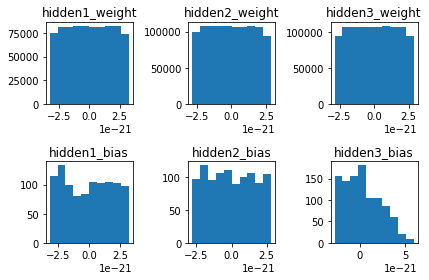

In [46]:
show_weight_bias(model)

A: 可以看到添加小的正则项，可以一定程度避免模型过拟合（训练和测试loss都在下降，而准确率都在提升。但添加过大的正则项则会导致训练失败，考虑L2正则化，目的是使各参数的元素尽可能小（靠近0），一旦正则化系数过大，模型就倾向于将所有参数都往0上靠，这样子很可能就无法拟合复杂的函数，从上述的模型参数直方图就可以看出这个结果（参数全部集中在0附近一个很小的区间，看坐标单位是1e-21）

### 4.2 dropout
Overfitting is a serious problem in large networks. And large networks are also slow to use, making it difficult to deal with overfitting by combining the predictions of many different large neural nets at test time. Dropout is a technique for addressing this problem. The key idea is to randomly drop units (along with their connections) from the neural network during training.

Click on this [link](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) for more details.

# 作业 5 
思考dropout的作用，使用dropout训练模型，观察和不使用dropout的结果之间的差异。

In [47]:
# TODO

# set hyper parameters and declare model, optimizer
# code here
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=1024, output_size=output_size).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=l2_norm)

In [48]:
# TODO

# Set dropout to True and probability = 0.5
# code here
model.set_use_dropout(True)

In [49]:
# TODO

# train and evaluate model
# code here
acc, loss = fit(train_loader, test_loader, model, loss_fn, optimizer, 5, get_grad=False)

Epoch: 1/5. Train set: Average loss: 0.4299, Accuracy: 93.6900
Epoch: 1/5. Validation set: Average loss: 15.3308, Accuracy: 93.6900
Epoch: 2/5. Train set: Average loss: 0.1376, Accuracy: 96.7133
Epoch: 2/5. Validation set: Average loss: 9.1338, Accuracy: 96.4200
Epoch: 3/5. Train set: Average loss: 0.0893, Accuracy: 97.8283
Epoch: 3/5. Validation set: Average loss: 7.3007, Accuracy: 97.1800
Epoch: 4/5. Train set: Average loss: 0.0628, Accuracy: 98.1717
Epoch: 4/5. Validation set: Average loss: 7.1259, Accuracy: 97.1400
Epoch: 5/5. Train set: Average loss: 0.0455, Accuracy: 98.9900
Epoch: 5/5. Validation set: Average loss: 5.6648, Accuracy: 97.7800


A: 从上述训练结果可以看出，dropout能够一定程度上避免过拟合。因在模型隐层参数量大于训练数据量时，依然能够使模型保持很好的效果：训练和测试loss都在下降，精度都在提升，仍处在学习阶段。

### 4.3 batch normalization
Batch normalization is a technique for improving the performance and stability of artificial neural networks

\begin{equation}
    y=\frac{x-E[x]}{\sqrt{Var[x]+\epsilon}} * \gamma + \beta, 
\end{equation}

$\gamma$ and $\beta$ are learnable parameters

Click on this [link](https://arxiv.org/abs/1502.03167) for more details.

# 作业 6 
思考batch normalization的作用，使用batch normalization训练模型，观察和不使用batch normalization的结果之间的差异。

In [50]:
# TODO

# set hyper parameters and declare model, optimizer
# code here
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=1024, output_size=output_size).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=l2_norm)

In [51]:
# TODO

# Set batch normalization to True 
# code here
model.set_use_bn(True)

In [52]:
# TODO

# train and evaluate model
# code here
acc, loss = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad=False)

Epoch: 1/5. Train set: Average loss: 0.1612, Accuracy: 97.8900
Epoch: 1/5. Validation set: Average loss: 7.8066, Accuracy: 96.7500
Epoch: 2/5. Train set: Average loss: 0.0431, Accuracy: 99.0733
Epoch: 2/5. Validation set: Average loss: 5.7808, Accuracy: 97.7400
Epoch: 3/5. Train set: Average loss: 0.0132, Accuracy: 99.7133
Epoch: 3/5. Validation set: Average loss: 4.7178, Accuracy: 98.0600
Epoch: 4/5. Train set: Average loss: 0.0040, Accuracy: 99.8983
Epoch: 4/5. Validation set: Average loss: 4.4919, Accuracy: 98.2900
Epoch: 5/5. Train set: Average loss: 0.0014, Accuracy: 99.9567
Epoch: 5/5. Validation set: Average loss: 4.1487, Accuracy: 98.4000


A: 这一个实验再次说明了好的避免过拟合的方法有多重要，哪怕训练集的准确率都已经到了99%+，但测试集的loss依然在降低，精度依然在提升。

### 4.4 data augmentation
PyTorch provides many transformation methods for data augmentation.

Click on this [link](https://pytorch.org/docs/stable/torchvision/transforms.html) for more details.

## 作业 7
思考data augmentation的作用，使用data augmentation训练模型（具体transform方式不限），观察和不使用data augmentation的结果之间的差异。

In [53]:
# TODO

# use data augmentation
# reload train_loader with transform
# code here
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, 4),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', 
                            train=True, 
                            transform=train_transform,
                            download=True)

In [56]:
# TODO

# set hyper parameters and declare model, optimizer
# code here
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=1024, output_size=output_size).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=l2_norm)

In [57]:
# TODO

# train and evaluate model
# code here
acc, loss = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad=False)

Epoch: 1/5. Train set: Average loss: 0.4125, Accuracy: 93.6183
Epoch: 1/5. Validation set: Average loss: 15.7287, Accuracy: 93.5700
Epoch: 2/5. Train set: Average loss: 0.1316, Accuracy: 95.8367
Epoch: 2/5. Validation set: Average loss: 11.0462, Accuracy: 95.4400
Epoch: 3/5. Train set: Average loss: 0.0842, Accuracy: 97.1850
Epoch: 3/5. Validation set: Average loss: 8.4213, Accuracy: 96.5200
Epoch: 4/5. Train set: Average loss: 0.0576, Accuracy: 98.1767
Epoch: 4/5. Validation set: Average loss: 6.9655, Accuracy: 97.0800
Epoch: 5/5. Train set: Average loss: 0.0401, Accuracy: 98.6133
Epoch: 5/5. Validation set: Average loss: 6.5192, Accuracy: 97.3000


A: 同样，通过增加训练集数目，也能够有效避免过拟合，使模型的泛化能力更强，进而在测试集上取得更好的表现。

## 5. Gradient explosion and vanishing

For plotting how gradients change, you need to set **get_grad=True** in **fit function**.

## 作业 8
调整超参数或改变初始化方式，分别产生梯度爆炸和梯度消失两种情况，观察它们与正常情况下梯度的变化曲线。

Epoch: 1/5. Train set: Average loss: 0.5175, Accuracy: 92.2317
Epoch: 1/5. Validation set: Average loss: 19.0557, Accuracy: 91.9100
Epoch: 2/5. Train set: Average loss: 0.1644, Accuracy: 95.5383
Epoch: 2/5. Validation set: Average loss: 11.5114, Accuracy: 95.4500
Epoch: 3/5. Train set: Average loss: 0.1138, Accuracy: 97.1467
Epoch: 3/5. Validation set: Average loss: 8.3177, Accuracy: 96.6000
Epoch: 4/5. Train set: Average loss: 0.0857, Accuracy: 97.7133
Epoch: 4/5. Validation set: Average loss: 7.4869, Accuracy: 96.9500
Epoch: 5/5. Train set: Average loss: 0.0670, Accuracy: 98.2333
Epoch: 5/5. Validation set: Average loss: 6.8826, Accuracy: 97.1900


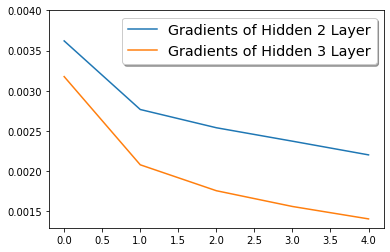

In [58]:
# TODO

# normal gradient
# code here
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=l2_norm)
acc, loss = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad=True)

Epoch: 1/5. Train set: Average loss: 40.8877, Accuracy: 9.9300
Epoch: 1/5. Validation set: Average loss: 3087.9724, Accuracy: 10.3200
Epoch: 2/5. Train set: Average loss: 41.8611, Accuracy: 9.9300
Epoch: 2/5. Validation set: Average loss: 2142.1513, Accuracy: 10.3200
Epoch: 3/5. Train set: Average loss: 41.9012, Accuracy: 9.7367
Epoch: 3/5. Validation set: Average loss: 2692.7707, Accuracy: 9.8200
Epoch: 4/5. Train set: Average loss: 42.0554, Accuracy: 9.8633
Epoch: 4/5. Validation set: Average loss: 3334.9157, Accuracy: 9.5800
Epoch: 5/5. Train set: Average loss: 41.3562, Accuracy: 9.8633
Epoch: 5/5. Validation set: Average loss: 3549.3894, Accuracy: 9.5800


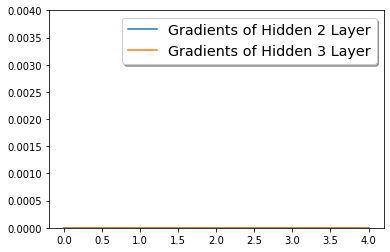

In [68]:
# TODO

# gradient explosion
# code here
def weight_bias_reset_explosion(model):
    """Custom initialization, you can imitate the code writing to use other initialization methods in homework.
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            mean, std = 0.05, 0.2
            torch.nn.init.normal_(m.weight, mean, std)
            torch.nn.init.normal_(m.bias, mean, std)

model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=1024, output_size=output_size, activation_function='SIGMOID').to(device)
weight_bias_reset_explosion(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=l2_norm)
acc, loss = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad=True)

Epoch: 1/5. Train set: Average loss: 0.8023, Accuracy: 88.7700
Epoch: 1/5. Validation set: Average loss: 27.0412, Accuracy: 89.3000
Epoch: 2/5. Train set: Average loss: 0.2773, Accuracy: 92.0000
Epoch: 2/5. Validation set: Average loss: 20.2995, Accuracy: 92.1800
Epoch: 3/5. Train set: Average loss: 0.2274, Accuracy: 93.4617
Epoch: 3/5. Validation set: Average loss: 17.1144, Accuracy: 93.5100
Epoch: 4/5. Train set: Average loss: 0.1953, Accuracy: 94.4350
Epoch: 4/5. Validation set: Average loss: 15.0364, Accuracy: 94.3900
Epoch: 5/5. Train set: Average loss: 0.1710, Accuracy: 95.1667
Epoch: 5/5. Validation set: Average loss: 13.4966, Accuracy: 95.0100


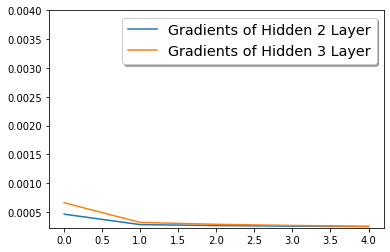

In [62]:
# TODO

# gradient vanishing
# code here
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=1024, output_size=output_size, activation_function='SIGMOID').to(device)
weight_bias_reset(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=l2_norm)
acc, loss = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad=True)

A: 可以看到由于选用了Sigmoid函数$(\sigma'(z)\in[0,1])$，再加上权重用$\mathcal{N}(0,0.1)}进行初始化，导致梯度在反向传播时越乘越小，进而趋于0，最终导致梯度消失。